In [1]:
#Before the analysis you should have installed the packages needed
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import math
import numpy as np
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats import diagnostic as diag


# We would like all available data from 03/01/2007 until today.
start_date = '2007-01-03'
end = datetime.date.today()

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
JPMorgan = data.DataReader('JPM', 'yahoo', start_date, end)
BofA = data.DataReader('BAC', 'yahoo', start_date, end)


#some info on the downloaded dataset
JPMorgan.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3081.000000,3081.000000,3081.000000,3081.000000,3.081000e+03,3081.000000
mean,58.536160,57.270987,57.914784,57.911545,2.833698e+07,51.361476
std,23.646155,23.543115,23.594463,23.582792,2.259895e+07,25.595596
min,17.290001,14.960000,15.370000,15.900000,3.680000e+06,12.642586
25%,41.700001,40.529999,41.099998,41.029999,1.385900e+07,32.858818
50%,50.770000,49.930000,50.250000,50.320000,2.084340e+07,40.618744
75%,65.910004,65.059998,65.419998,65.540001,3.471650e+07,60.044895
max,119.330002,118.080002,119.129997,118.769997,2.172942e+08,116.856049


In [2]:
print(JPMorgan.shape)
JPMorgan.head()

(3081, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,48.369999,47.590000,48.000000,48.070000,14244700.0,35.611729
2007-01-04,48.549999,47.750000,48.049999,48.189999,9471500.0,35.700626
2007-01-05,48.250000,47.630001,48.169998,47.790001,10760500.0,35.404289
2007-01-08,48.060001,47.320000,47.570000,47.950001,8239200.0,35.522823
2007-01-09,48.110001,47.360001,47.900002,47.750000,9276700.0,35.374649


In [3]:
#some info on the downloaded dataset
BofA.describe()

,High,Low,Open,Close,Volume,Adj Close
count,3081.000000,3081.000000,3081.000000,3081.000000,3.081000e+03,3081.000000
mean,20.611185,20.061886,20.354297,20.326894,1.300711e+08,18.527801
std,11.788258,11.570375,11.690419,11.678539,1.151496e+08,9.773850
min,3.510000,2.530000,3.220000,3.140000,8.331400e+06,2.865187
25%,13.380000,13.000000,13.210000,13.190000,6.130790e+07,12.174027
50%,16.330000,15.960000,16.170000,16.139999,9.621440e+07,15.060007
75%,26.430000,25.650000,25.990000,26.200001,1.598722e+08,25.127768
max,54.209999,53.709999,54.080002,54.049999,1.226791e+09,43.714695


In [4]:
print(BofA.shape)
BofA.head()

(3081, 6)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2007-01-03,54.180000,52.990002,53.400002,53.330002,16028200.0,42.720745
2007-01-04,53.889999,53.049999,53.330002,53.669998,13175000.0,42.993111
2007-01-05,53.590000,53.029999,53.590000,53.240002,10205000.0,42.648655
2007-01-08,53.639999,52.799999,53.459999,53.450001,9685900.0,42.816860
2007-01-09,53.709999,52.970001,53.599998,53.500000,12546500.0,42.856926


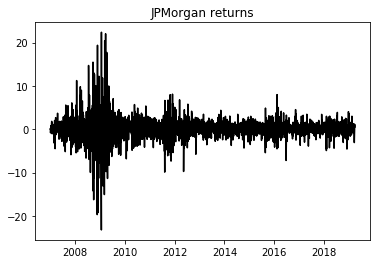

In [5]:
#compute log returns
JPMorgan['Log']=np.log(JPMorgan['Adj Close'])
Returns=np.diff(JPMorgan['Log'])*100
#We assume the first return  to be 0
Returns=np.append(0,Returns)
JPMorgan['Returns']=Returns

plt.plot(JPMorgan['Returns'],color='black')
plt.title('JPMorgan returns')
plt.show()

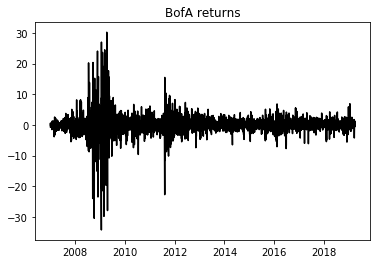

In [6]:
#compute log returns
BofA['Log']=np.log(BofA['Adj Close'])
Returns=np.diff(BofA['Log'])*100
#We assume the first return  to be 0
Returns=np.append(0,Returns)
BofA['Returns']=Returns

plt.plot(BofA['Returns'],color='black')
plt.title('BofA returns')
plt.show()

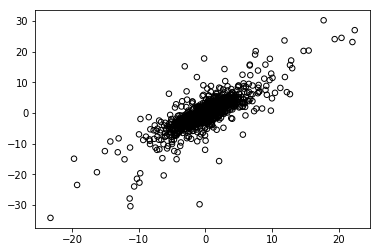

In [7]:
mdata = pd.concat([JPMorgan['Returns'], BofA['Returns']], axis=1)
mdata = mdata.values
plt.scatter(mdata[:,0] ,mdata[:,1]  , s=30, facecolors='none', edgecolors='black')
plt.show()
print()


In [8]:
correlation = np.corrcoef(mdata[:,0],mdata[:,1])
print(correlation)
stats.describe(mdata)

[[1.         0.81804208]
 [0.81804208 1.        ]]


DescribeResult(nobs=3081, minmax=(array([-23.2278068 , -34.20587515]), array([22.39168436, 30.20955921])), mean=array([ 0.03390848, -0.01419121]), variance=array([ 6.5178678 , 11.59237467]), skewness=array([ 0.31956845, -0.31439584]), kurtosis=array([16.08925413, 22.05870928]))

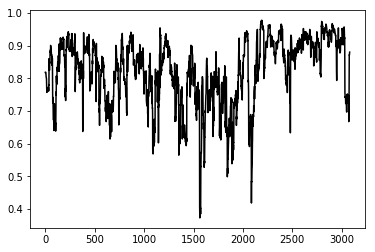

In [9]:

#EWMA in Python, as the is not a package for DCC
# subtract mean to the returns as we assume the returns model is a constant
mdata[:,0] = mdata[:,0]-np.mean(mdata[:,0])                       
mdata[:,1] = mdata[:,1]-np.mean(mdata[:,1])
T = len(mdata[:,0])
EWMA = np.full([T,3], np.nan)
#you can change the lambda to weight more the past variance or the past return
lmbda = 0.94
S = np.cov(mdata, rowvar = False)
EWMA[0,] = S.flatten()[[0,3,1]]
for i in range(1,T):
    S = lmbda * S + (1-lmbda) * np.transpose(np.asmatrix(mdata[i-1]))* np.asmatrix(mdata[i-1])
    EWMA[i,] = [S[0,0], S[1,1], S[0,1]]
EWMArho = np.divide(EWMA[:,2], np.sqrt(np.multiply(EWMA[:,0],EWMA[:,1])))
plt.plot(EWMArho,color='black')
plt.show()
#this plot is quite the same as obtained in R with the DCC model